# From Interest Rate Modelling, Andersen and Piterbarg, chapter 16

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from ito_diffusions import *
from volmodels import *
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
T = 1.0
SCHEME_STEPS = int(1e4)
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 500

## Diffusion equation

* $dX_t = \sigma C(X_t)dW_t$
* $C(x) = bx+(m-b)x_0 + (1-m)L$

## Sample paths

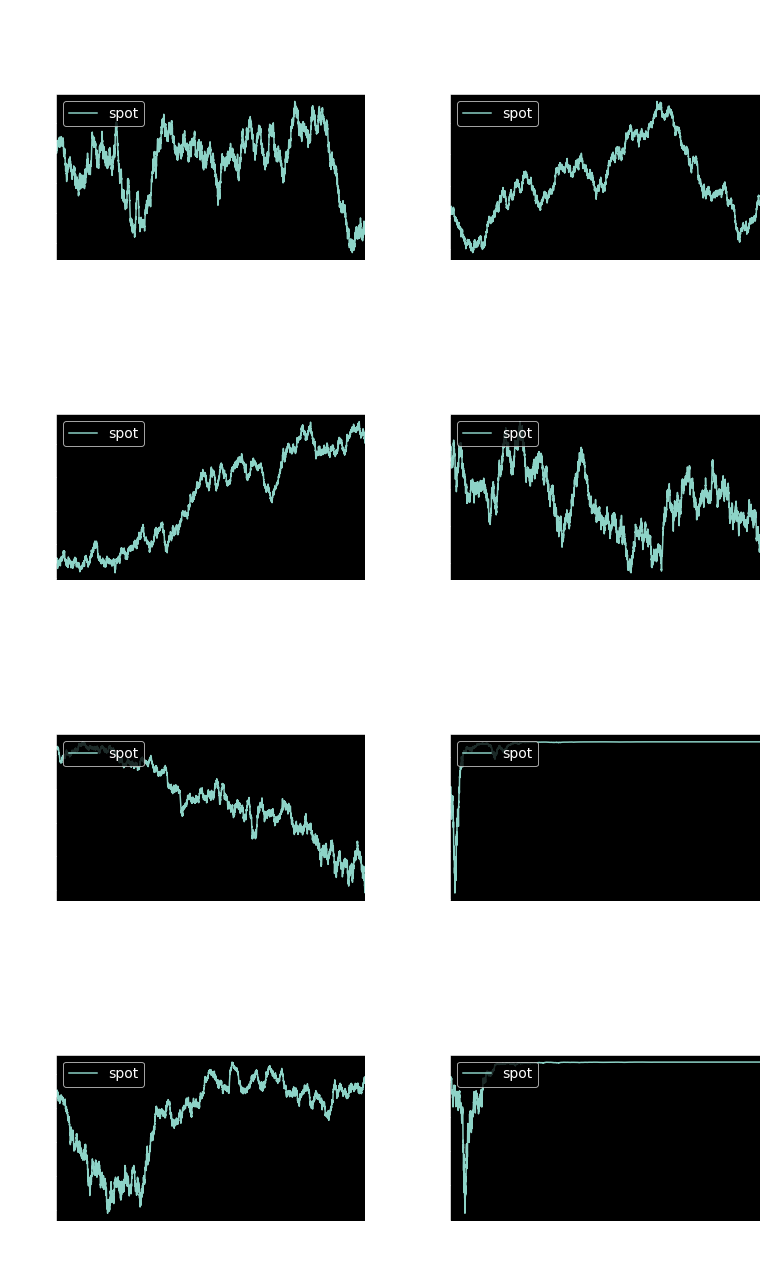

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=2)

x0 = 1.0
L = -5.0

params = [
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.1],
    [1.0, 0.9, 0.0],
    [1.0, 0.9, 0.1],
    [5.0, 0.0, 0.0],
    [5.0, 0.0, 0.1],
    [5.0, 0.9, 0.0],
    [5.0, 0.9, 0.1],
]

X = SLN(x0=x0, T=T, scheme_steps=SCHEME_STEPS, L=L)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        sigma = params[i+4*j][0]
        shift = params[i+4*j][1]
        mixing = params[i+4*j][2]
        
        X.sigma = sigma
        X.shift = shift
        X.mixing = mixing
        X.L = L
        
        df = X.simulate()
        df.plot(kind='line', ax=ax)

        ax.set_xlabel('time\n')
        ax.set_ylabel('spot')
        ax.legend(loc='upper left')
        ax.set_title(r'$\sigma$={:.2}'.format(sigma)+'\n'\
                     r'shift={:.0%}'.format(shift)+'\n'\
                     r'$mixing$={:.0%}'.format(mixing)+'\n'\
                     r'$L$={:.2}'.format(L)
                    )

plt.tight_layout()
plt.show()

## Numerical experiments

In [5]:
f = 2*ONE_PCT
shift = 0.8
mixing = 0.99
sigma = 50*ONE_PCT
L = f
moneyness_lo = 1/10
moneyness_hi = 3

In [6]:
Model_LN = SLN_adjustable_backbone_LN(sigma=sigma,
                                      shift=shift, 
                                      mixing=mixing, 
                                      L=L,
                                      f=f,
                                      n_strikes=N_STRIKES,
                                      moneyness_lo=moneyness_lo,
                                      moneyness_hi=moneyness_hi
                                     )

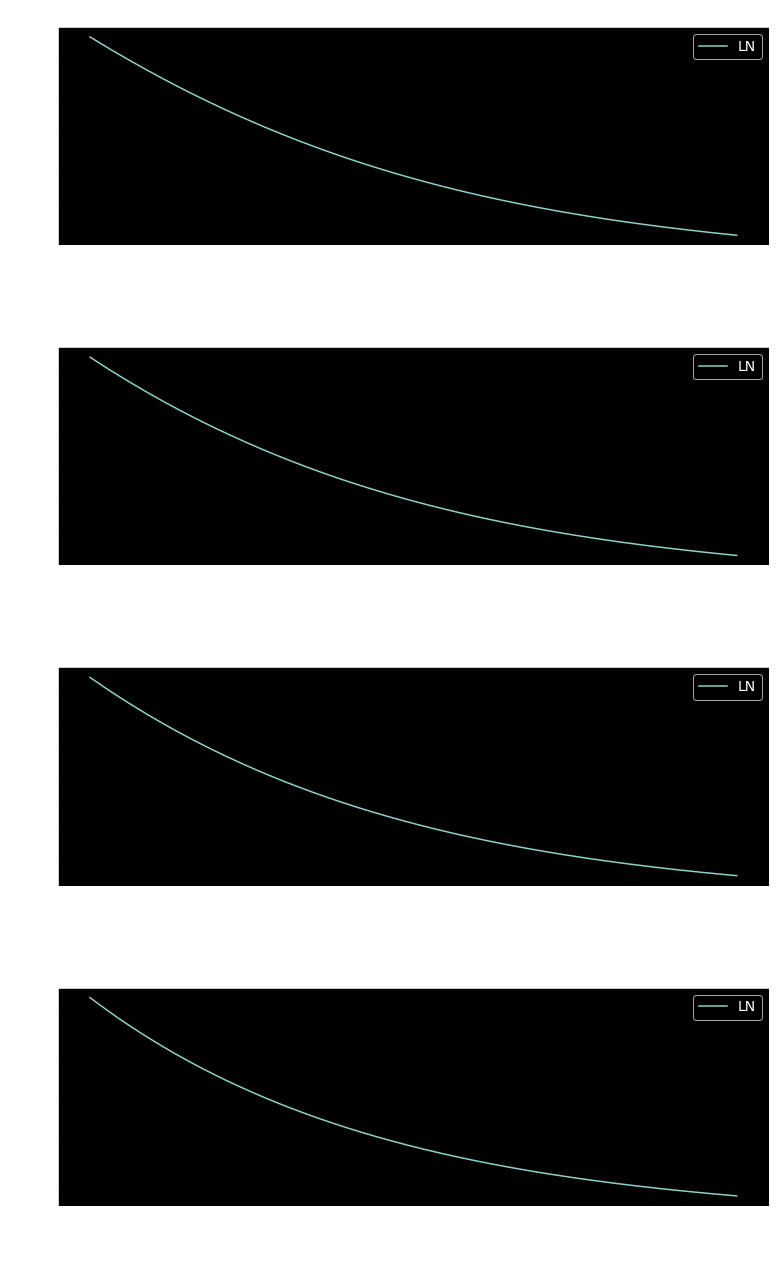

In [7]:
xlabel = 'logmoneyness\n\n'
ylabel = 'implied vol'

T_expiries = [1, 5, 10, 20]

fig, axes = plt.subplots(nrows=4, ncols=1)

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    x_grid = Model_LN.logmoneyness_grid
    #x_grid = Model_LN.strike_grid

    smile = list(Model_LN.smile.values())
    ax.plot(x_grid, smile, label='LN')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.set_title('expiry={}y'.format(T_expiry))

plt.tight_layout()
plt.show()

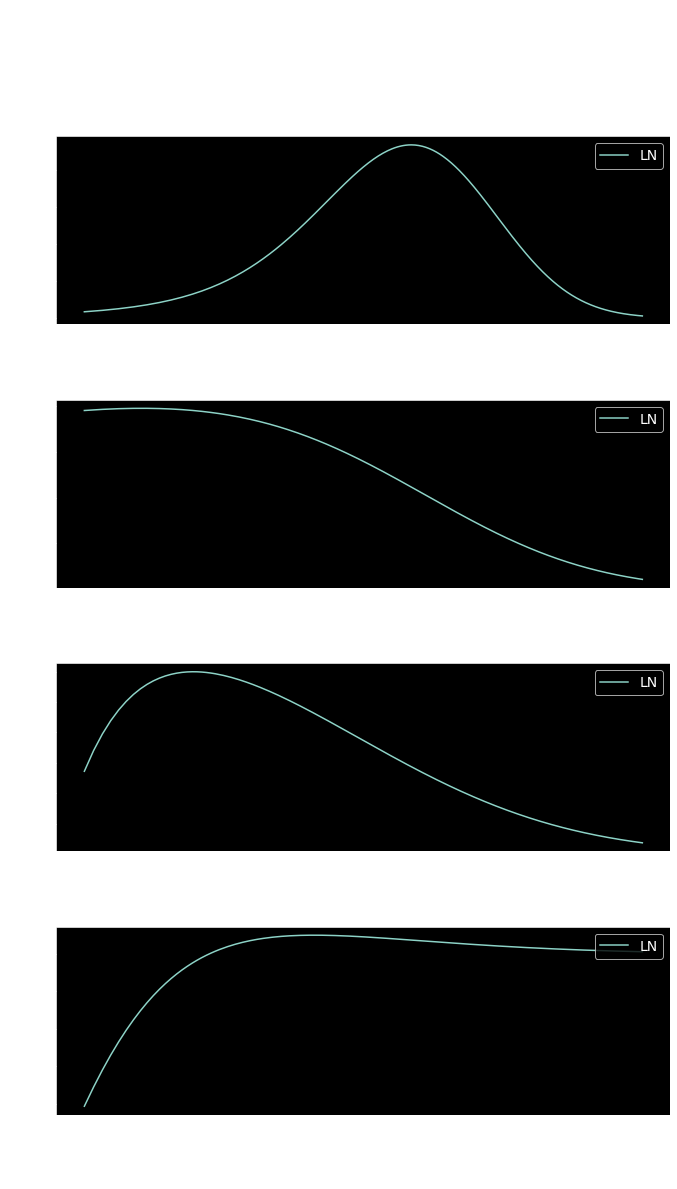

In [8]:
xlabel = 'logmoneyness\n\n'
ylabel = 'pdf'

T_expiries = [1, 5, 10, 20]

fig, axes = plt.subplots(nrows=4, ncols=1)

plt.suptitle(r'$f$={:.2%}'.format(Model_LN.f)+', ' +\
             r'$\sigma$={:.0%}'.format(Model_LN.sigma)+', ' +\
             r'shift={:.0%}'.format(Model_LN.shift)+', ' +\
             r'$mixing$={:.0%}'.format(Model_LN.mixing)+', '+\
             r'$L$={:}'.format(Model_LN.L)+', '+\
             r'ATM(LN)={:.2%}'.format(Model_LN.ATM))

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    
    x_grid = Model_LN.logmoneyness_grid
    #x_grid = Model_LN.strike_grid
    
    pdf_LN = list(Model_LN.pdf_curve.values())

    ax.plot(x_grid, pdf_LN, label='LN')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')

    ax.set_title(r'expiry={}y'.format(T_expiry))

plt.subplots_adjust(hspace=0.4)
plt.show()

## Backbone i.e ATM vol move implied by forward move

The smile dynamics is controlled by the shift and mixing parameters. The shift parameter also controls the ATM slope, however the mixing has no effect on that slope. Having both therefore allows one to calibrate independently slope and backbone; in particular, in lognormal space :

* $mixing=\frac{1+shift}{2}$ : flat Black backbone
* $mixing=\frac{shift}{2}$ : Gaussian backbone, the ATM is higher for lower forward.

Other behaviours (such as sticky delta) can be obtained with different values of mixing relative to shift.


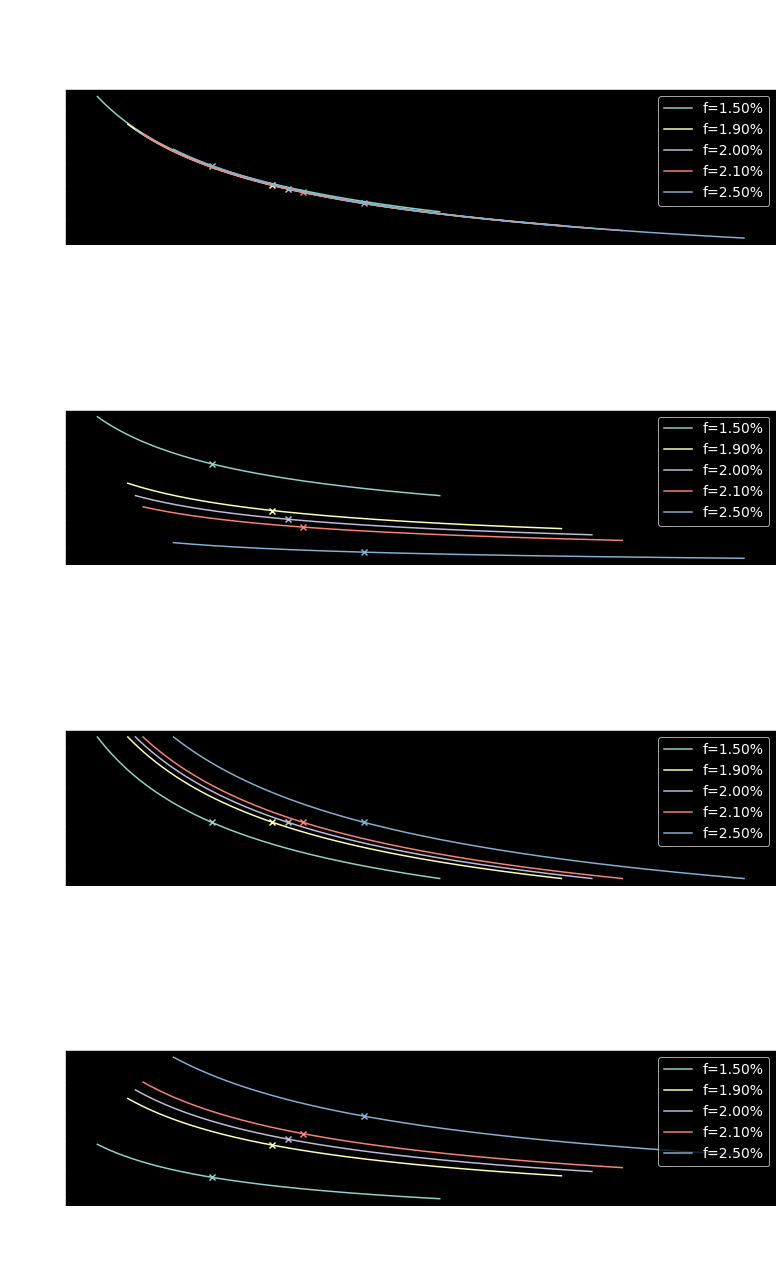

In [9]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT

shift = 0.8
sigma = 50*ONE_PCT
L = f

mixings = [
    0.5*(1+shift),
    0.5*shift,
    1,
    1.2,
]

f_shocks = [
    -50*ONE_BP, 
    -10*ONE_BP, 
    0, 
    10*ONE_BP, 
    50*ONE_BP
]

Model_LN = SLN_adjustable_backbone_LN(sigma=sigma, 
                                      shift=shift, 
                                      mixing=mixing, 
                                      L=L,
                                      f=f,
                                      n_strikes=N_STRIKES,
                                      moneyness_lo=0.5,
                                      moneyness_hi=2
                                     )

fig, axes = plt.subplots(nrows=4, ncols=1)
    
for i, ax in enumerate(axes):
    mixing = mixings[i]
    Model_LN.mixing= mixing
    for f_shock in f_shocks:
        Model_LN.f = f+f_shock
        smile = list(Model_LN.smile.values())
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(Model_LN.strike_grid, smile, label=label)
        ax.scatter([Model_LN.f], [Model_LN.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
        ax.set_title('{}\n'.format(Model_LN.vol_type)\
                     +r'$shift$={}'.format(Model_LN.shift)+'\n'\
                     +r'mixing={}'.format(Model_LN.mixing)+'\n',\
                    )

plt.tight_layout()
plt.show()

## Parameter sensitivities

* shift controls the ATM slope of the smile
* mixing is orthogonal to shift (at least for L in the neighborhood of the initial forward) and has no effect on the smile
* $\sigma$ controls directly the ATM vol and induces parallel translation of the whole smile
* $L$ has a tiny effect of parallel translation of the smile. It is better to hold it constant to the value of the initial forward to ensure orthogonality of shift and mixing and only update it periodically.

Main drawback of this parametrization is that it does not allow to control the convexity of the smile nor its wings. That is a typical weakness of local volatility model that can be corrected by introducing stochastic volatility i.e typically by making $\sigma$ follow a diffusive process.


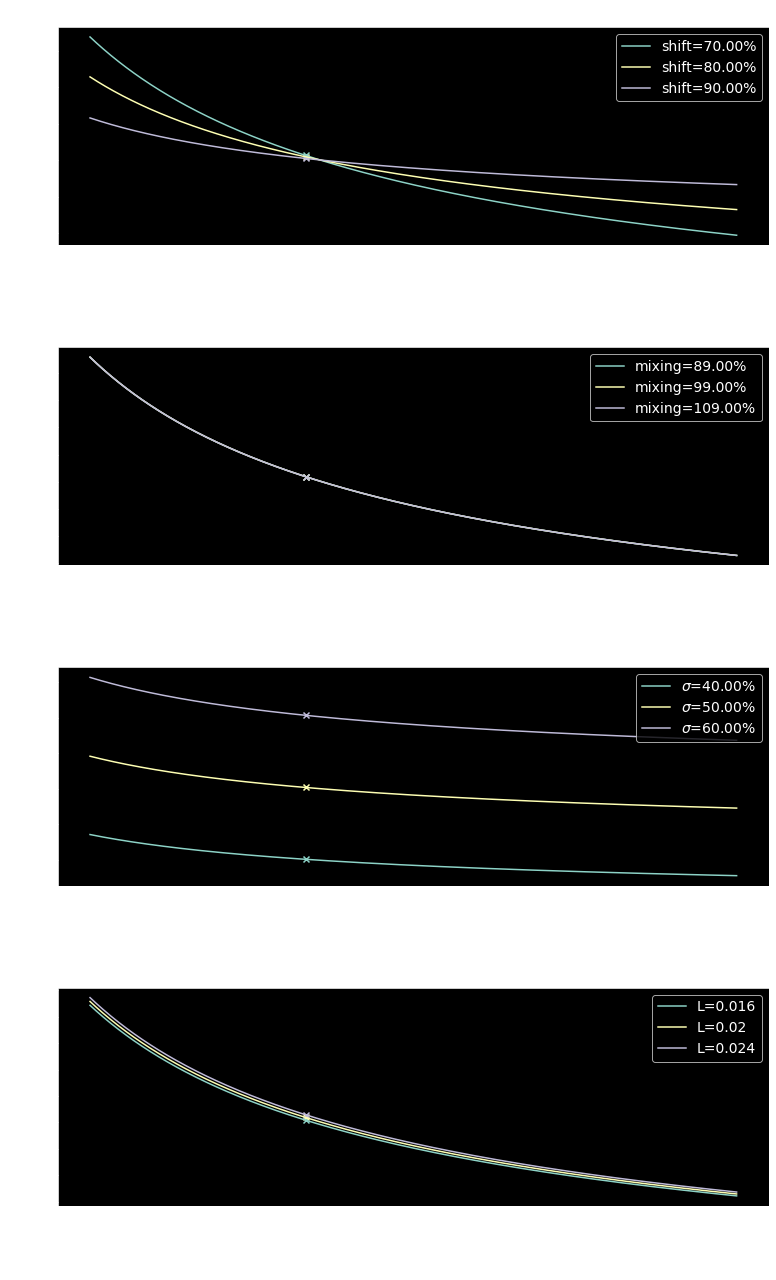

In [10]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT
shift = 0.8
mixing = 0.99
sigma = 50*ONE_PCT
L = f

shift_shocks = [-0.1, 0, 0.1]
mixing_shocks = [-0.1, 0, 0.1]
sigma_shocks = [-0.1, 0, 0.1]
L_shocks = [-0.2, 0, 0.2]

fig, axes = plt.subplots(nrows=4, ncols=1)

ax = axes[0]  
model = SLN_adjustable_backbone_LN(sigma=sigma, 
                                   shift=shift,
                                   mixing=mixing,
                                   L=L,
                                   f=f,
                                   n_strikes=N_STRIKES,
                                   moneyness_lo=0.5,
                                   moneyness_hi=2
                                  )

for shift_shock in shift_shocks:
    model.shift = shift+shift_shock
    
    smile = list(model.smile.values())
    label = 'shift={:.2%}'.format(shift+shift_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title('Shift shock')

ax = axes[1]
model = SLN_adjustable_backbone_LN(sigma=sigma, 
                                   shift=shift, 
                                   mixing=mixing, 
                                   L=L,
                                   f=f,
                                   n_strikes=N_STRIKES,
                                   moneyness_lo=0.5, 
                                   moneyness_hi=2
                                  )

for mixing_shock in mixing_shocks:
    model.mixing = mixing+mixing_shock
    
    smile = list(model.smile.values())
    label = 'mixing={:.2%}'.format(mixing+mixing_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title('Mixing shock')
    
ax = axes[2]
model = SLN_adjustable_backbone_LN(sigma=sigma,
                                   shift=shift,
                                   mixing=mixing, 
                                   L=L,
                                   f=f,
                                   n_strikes=N_STRIKES,
                                   moneyness_lo=0.5, 
                                   moneyness_hi=2
                                  )

for sigma_shock in sigma_shocks:
    model.sigma = sigma+sigma_shock

    smile = list(model.smile.values())
    label = r'$\sigma$={:.2%}'.format(sigma+sigma_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title(r'$\sigma$ shock')

ax = axes[3]
model = SLN_adjustable_backbone_LN(sigma=sigma, 
                                   shift=shift, 
                                   mixing=mixing, 
                                   L=L,
                                   f=f,
                                   n_strikes=N_STRIKES,
                                   moneyness_lo=0.5, 
                                   moneyness_hi=2
                                  )

for L_shock in L_shocks:
    model.L = L*(1+L_shock)
    smile = list(model.smile.values())
    label = r'L={:.2}'.format(model.L)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title(r'L shock')
    
plt.tight_layout()
plt.show()